In [ ]:
import cv2  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import math
from google.colab.patches import cv2_imshow
from google.colab import files 
from scipy import signal

Gaussian blur

In [ ]:
def mygaussianblur(img,radius,sigma):
    gaussMatrix = np.zeros(2*radius+1)
    gaussSum = 0
    
    a = 1/(math.sqrt(2*math.pi))
    b = -1/(2*sigma**2)
    h = img.shape[0]
    w = img.shape[1]

    for i in range(-radius,radius+1):
      gaussMatrix[i+radius] = a*np.exp(b*i**2)
    #Normalization
    gaussMatrix = gaussMatrix/gaussMatrix.sum()

    for y in range(h):    #x方向
      for x in range(w-radius):
        gaussSum = 0
        for j in range(-radius,radius+1):
          if x+j>=0 and x+j<w:
            gaussSum += gaussMatrix[j+radius]*img[y][x+j]
        img[y][x] = gaussSum
    
    for x in range(w):    #y方向
      for y in range(h-radius):
        gaussSum = 0
        for j in range(-radius,radius+1):
          if y+j>=0 and y+j<h :
            gaussSum += gaussMatrix[j+radius]*img[y+j][x]
        img[y][x] = gaussSum
    
    return img

sharpen

In [ ]:
def laplacian_sharpening(img):

  l_filter = np.array([[0,1,0],[1,-4,1],[0,1,0]])
  rows = np.size(img,0)
  cols = np.size(img,1)
  result = np.zeros(img.shape)

  for i in range(0,rows-2):
    for j in range(0,cols-2):
      l = sum(sum(l_filter*img[i:i+3,j:j+3]))
      result[i+1,j+1] = l

  return result

Sobel filter

In [ ]:
#vertical Sobel filter
def v_sobel(img):
  h_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
  rows = np.size(img,0)
  cols = np.size(img,1)
  gradient_magnitude_1 = np.zeros(img.shape)

  for i in range(0,rows-2):
    for j in range(0,cols-2):
      vertical = sum(sum(h_filter*img[i:i+3,j:j+3]))
      gradient_magnitude_1[i+1,j+1] = vertical

  return gradient_magnitude_1

#horizontal Sobel filter
def h_sobel(img):
  h_filter = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
  rows = np.size(img,0)
  cols = np.size(img,1)
  gradient_magnitude_2 = np.zeros(img.shape)

  for i in range(0,rows-2):
    for j in range(0,cols-2):
      horizontal = sum(sum(h_filter*img[i:i+3,j:j+3]))
      gradient_magnitude_2[i+1,j+1] = horizontal

  return gradient_magnitude_2

def mysobel(gradient_magnitude_1,gradient_magnitude_2,threshold):
  #print(gradient_magnitude_1.shape)
  gradient_magnitude = np.zeros(gradient_magnitude_1.shape)
  rows = np.size(gradient_magnitude_1,0)
  cols = np.size(gradient_magnitude_1,1)
  
  for i in range(0,rows-2):
    for j in range(0,cols-2):
      gradient_magnitude[i+1,j+1] = np.sqrt((gradient_magnitude_1[i+1,j+1]**2 + gradient_magnitude_2[i+1,j+1]**2))

  for a in range(rows):
    for b in range(cols):
      if gradient_magnitude[a,b] < threshold:
        gradient_magnitude[a,b] = 0

  theta = np.arctan2(gradient_magnitude_1, gradient_magnitude_1)

  return gradient_magnitude, theta


In [ ]:
def non_max_suppression(img, D):
    M, N = img.shape[0], img.shape[1]  
    Z = np.zeros((M,N))
    angle = D*180./np.pi
    angle[angle<0] += 180
    
    for i in range(1,M-1):
      for j in range(1,N-1):
        try:
          q = 255
          r = 255
          #angle 0
          if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
            q = img[i,j+1]
            r = img[i,j-1]
          #angle 45
          elif (22.5 <= angle[i,j] < 67.5):
            q = img[i+1,j-1]
            r = img[i-1,j+1]
          #angle 90
          elif (67.5 <= angle[i,j] < 112.5):
            q = img[i+1,j]
            r = img[i-1,j]
          #angle 135
          elif (112.5 <= angle[i,j] < 157.5):
            q = img[i-1,j-1]
            r = img[i+1,j+1]

          if (img[i,j] >= q) and (img[i,j] >= r):
            Z[i,j] = img[i,j]
          else:
            Z[i,j] = 0

        except IndexError as e:
          pass
          
    return Z

In [ ]:
def threshold(img, low, high, weak):
    output = np.zeros((img.shape[0],img.shape[1]))
    strong = 255

    strong_row, strong_col = np.where(img >= high)
    weak_row, weak_col = np.where((img <= high) & (img >= low))

    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak

    return output

In [ ]:
def hysteresis(img, weak, strong):
  M, N = img.shape[0], img.shape[1]  
  for i in range(1,M-1):
    for j in range(1,N-1):
      if (img[i,j] == weak):
        try:
          if ((img[i+1,j-1] == strong) or (img[i+1,j] == strong) or (img[i+1,j+1] == strong)
            or (img[i,j-1] == strong) or (img[i,j+1] == strong)
            or (img[i-1,j-1] == strong) or (img[i-1,j] == strong) or (img[i-1,j+1] == strong)):
            img[i,j] = strong
          else:
            img[i,j] = 0
        except IndexError as e:
          pass
  return img

canny edge detection

In [ ]:
def canny_detect(img,s_threshold,low,high,weak):
  #grayscale conversion
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  #Gaussian blur
  blur_img = mygaussianblur(gray_img,3,1)
  #Sobel filter
  mag1 = v_sobel(blur_img)
  mag2 = h_sobel(blur_img)
  mag,theta = mysobel(mag1,mag2,s_threshold)
  nms_img = non_max_suppression(mag,theta)
  dt_img = threshold(nms_img,low,high,weak)
  edge_img = hysteresis(dt_img,weak,255)

  return edge_img

color image canny edge detection

In [ ]:
def color_canny_detect(img,s_threshold,low,high,weak):
  #Gaussian blur
  blur_img = mygaussianblur(img[:,:,0],3,1)
  #blur_img.reshape(img.shape[0],img.shape[1]*img.shape[2])
  #Sobel filter
  mag1 = v_sobel(blur_img)
  mag2 = h_sobel(blur_img)
  mag,theta = mysobel(mag1,mag2,s_threshold)
  nms_img = non_max_suppression(mag,theta)
  dt_img = threshold(nms_img,low,high,weak)
  edge_img = hysteresis(dt_img,weak,255)

  return edge_img

edge detection with sharpening

In [ ]:
def sharp_edge_detect(img,s_threshold,low,high,weak):

  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  sharp = laplacian_sharpening(gray_img)
  sharp_img = gray_img - sharp
  mag1 = v_sobel(sharp_img)
  mag2 = h_sobel(sharp_img)
  mag,theta = mysobel(mag1,mag2,s_threshold)
  nms_img = non_max_suppression(mag,theta)
  dt_img = threshold(nms_img,low,high,weak)
  edge_img = hysteresis(dt_img,weak,255)

  return edge_img

In [ ]:
#load img
img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')
img3 = cv2.imread('img3.jpg')
img4 = cv2.imread('img4.jpg')


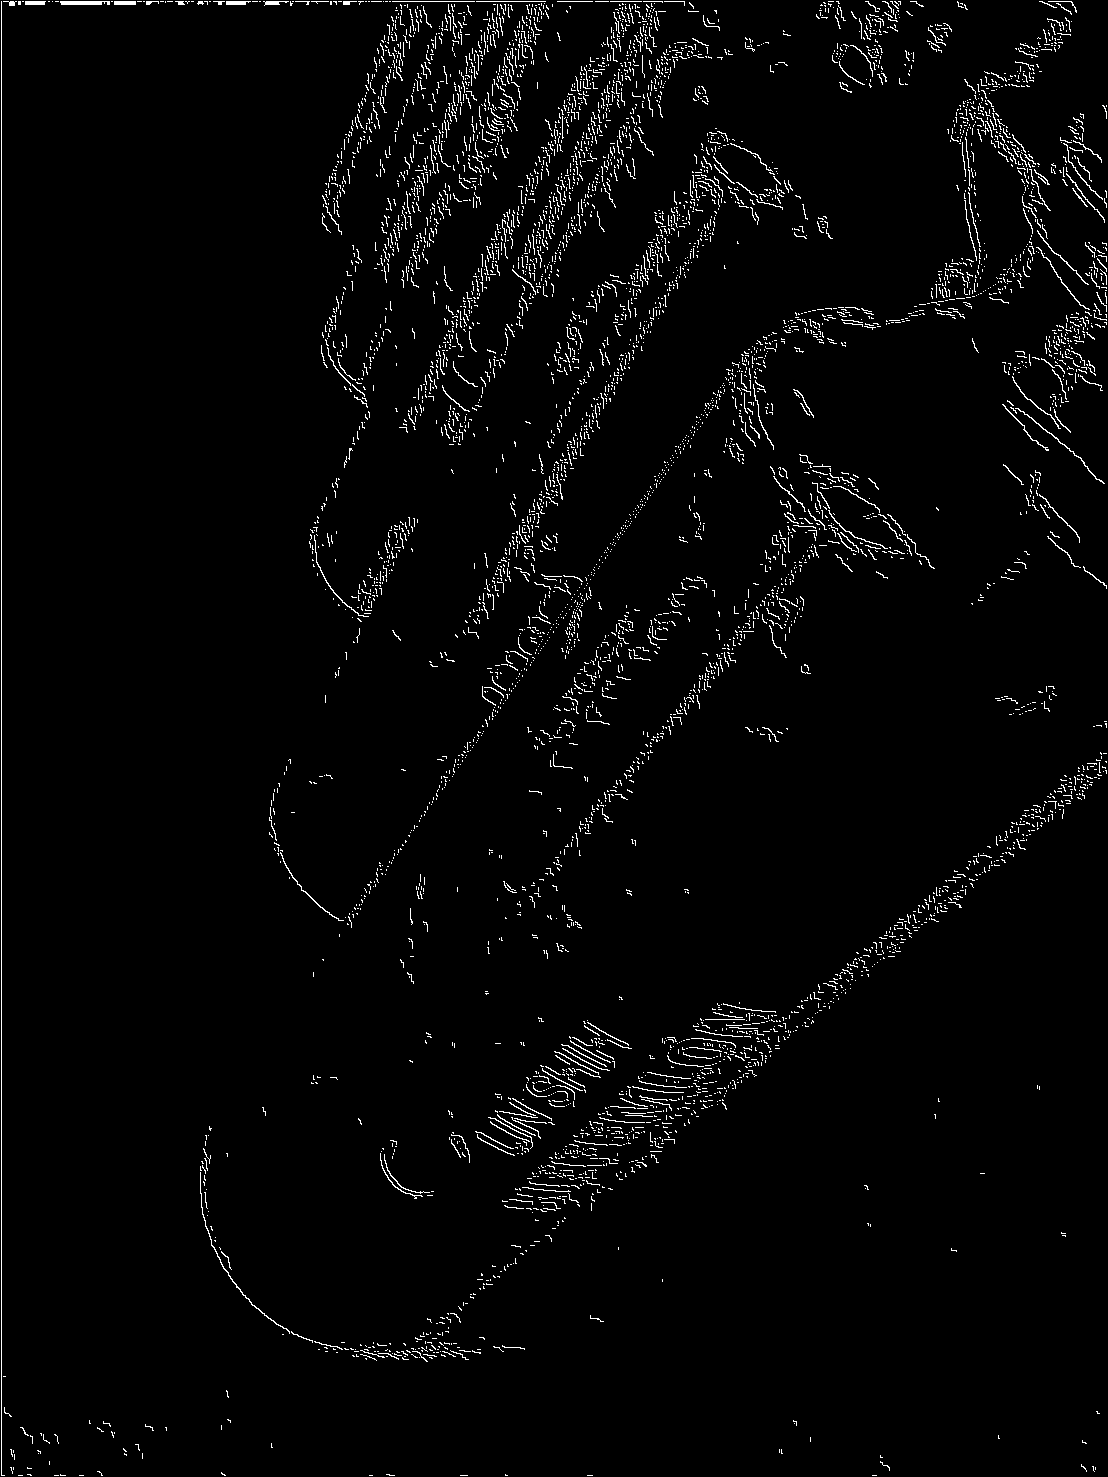

In [ ]:
edge_img1 = canny_detect(img1,10,5,50,50)
cv2.imwrite('your_path', edge_img1) 
cv2_imshow(edge_img1)

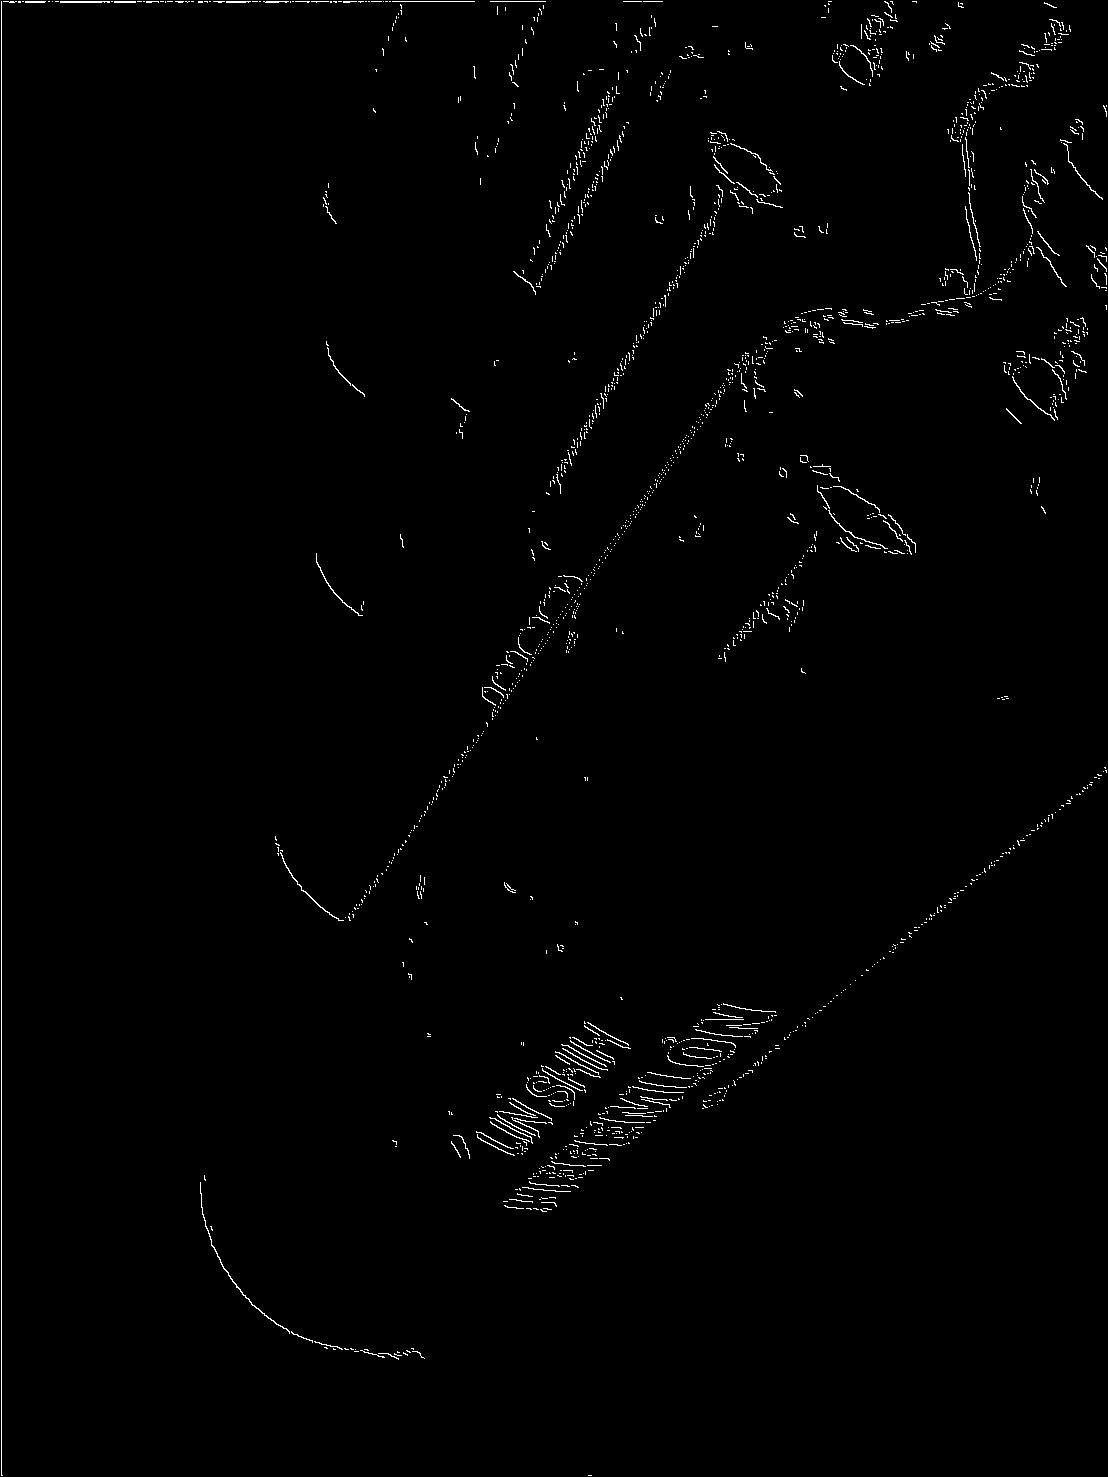

In [ ]:
edge_img1 = canny_detect(img1,10,50,100,50)
cv2.imwrite('your_path', edge_img1)
cv2_imshow(edge_img1)

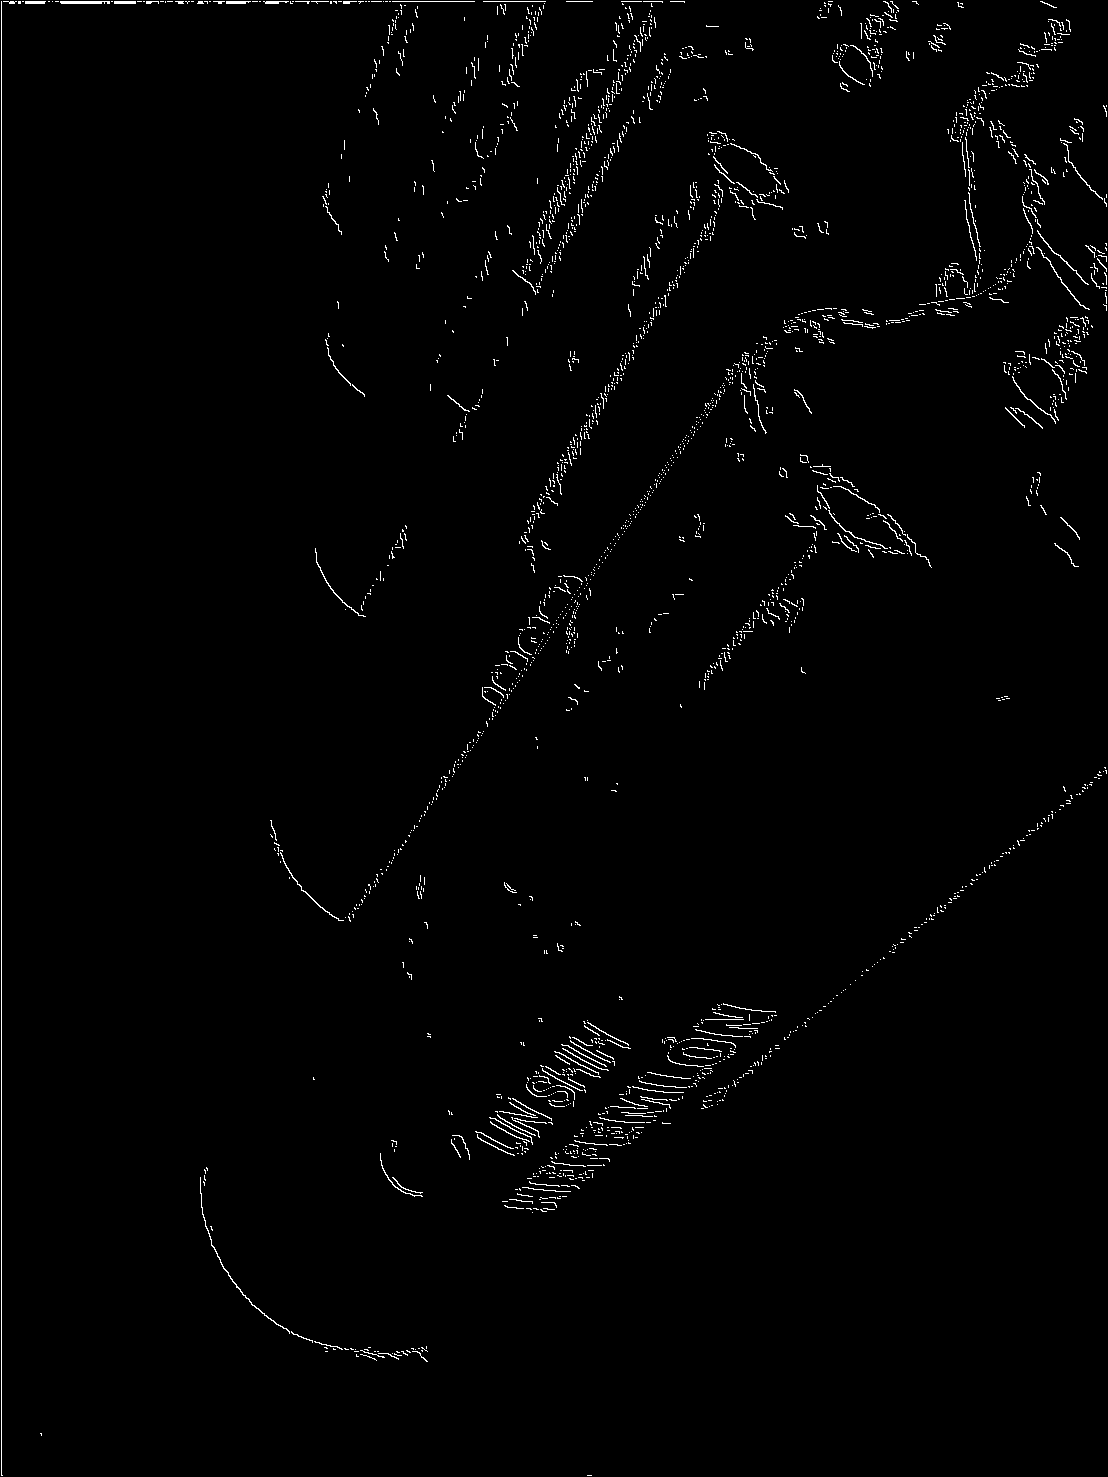

In [ ]:
edge_img1 = canny_detect(img1,10,30,80,50)
cv2.imwrite('your_path', edge_img1)
cv2_imshow(edge_img1)

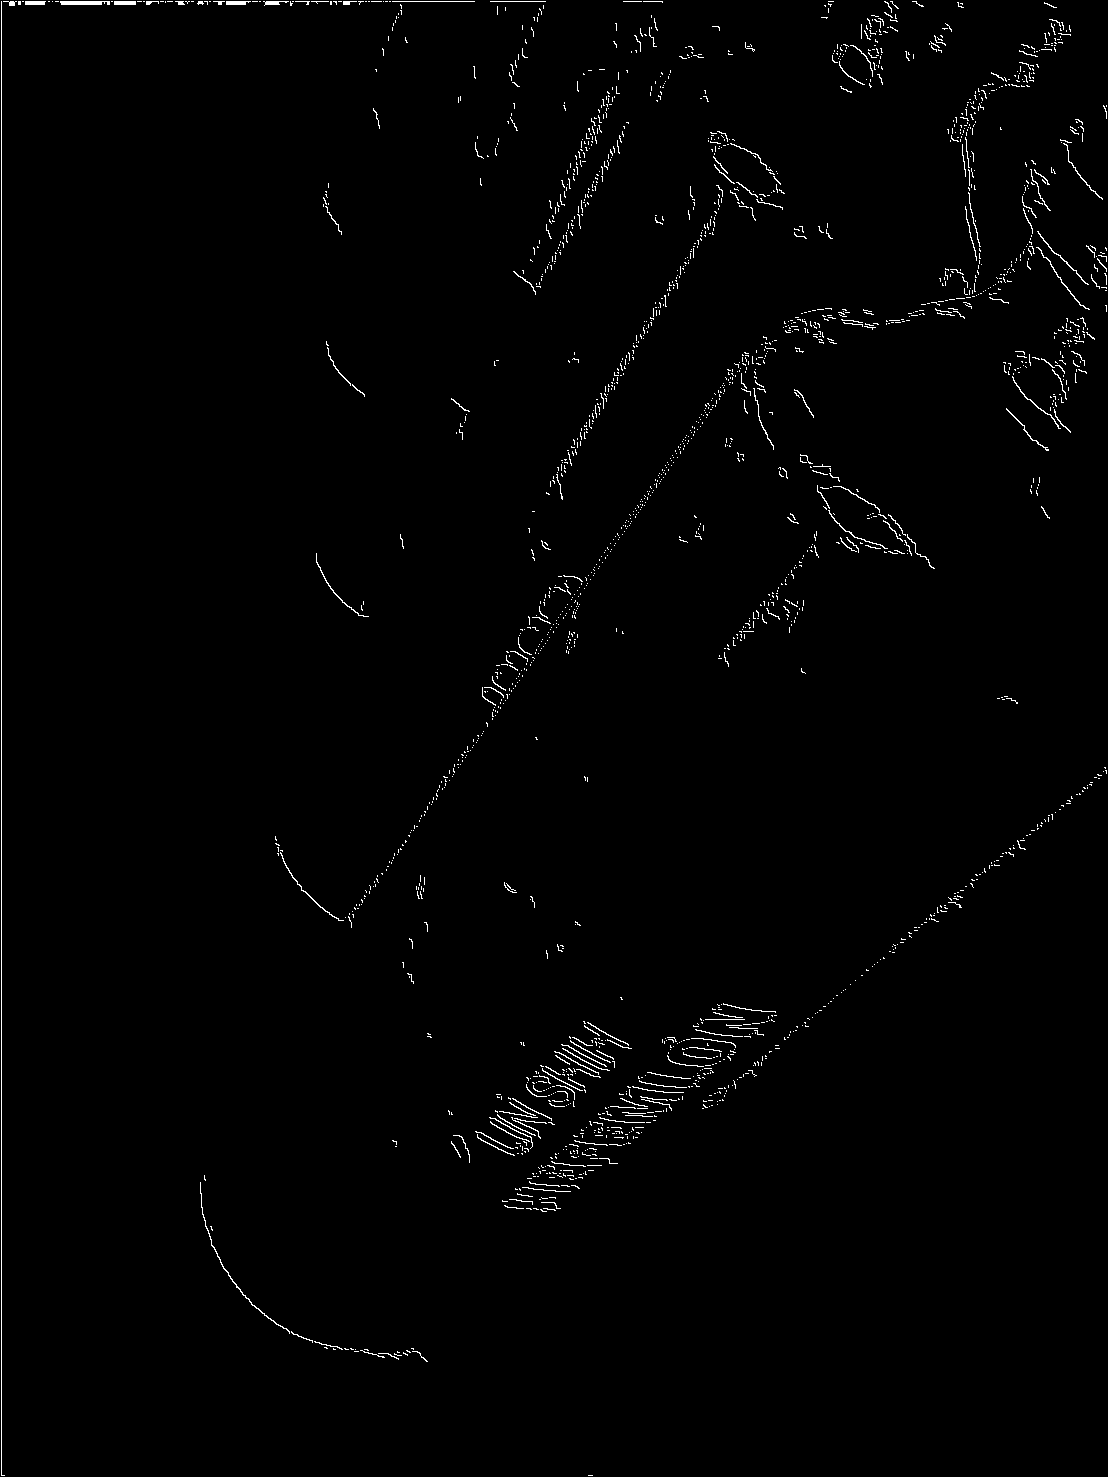

In [ ]:
edge_img1 = canny_detect(img1,10,5,100,50)
cv2.imwrite('your_path', edge_img1)
cv2_imshow(edge_img1)

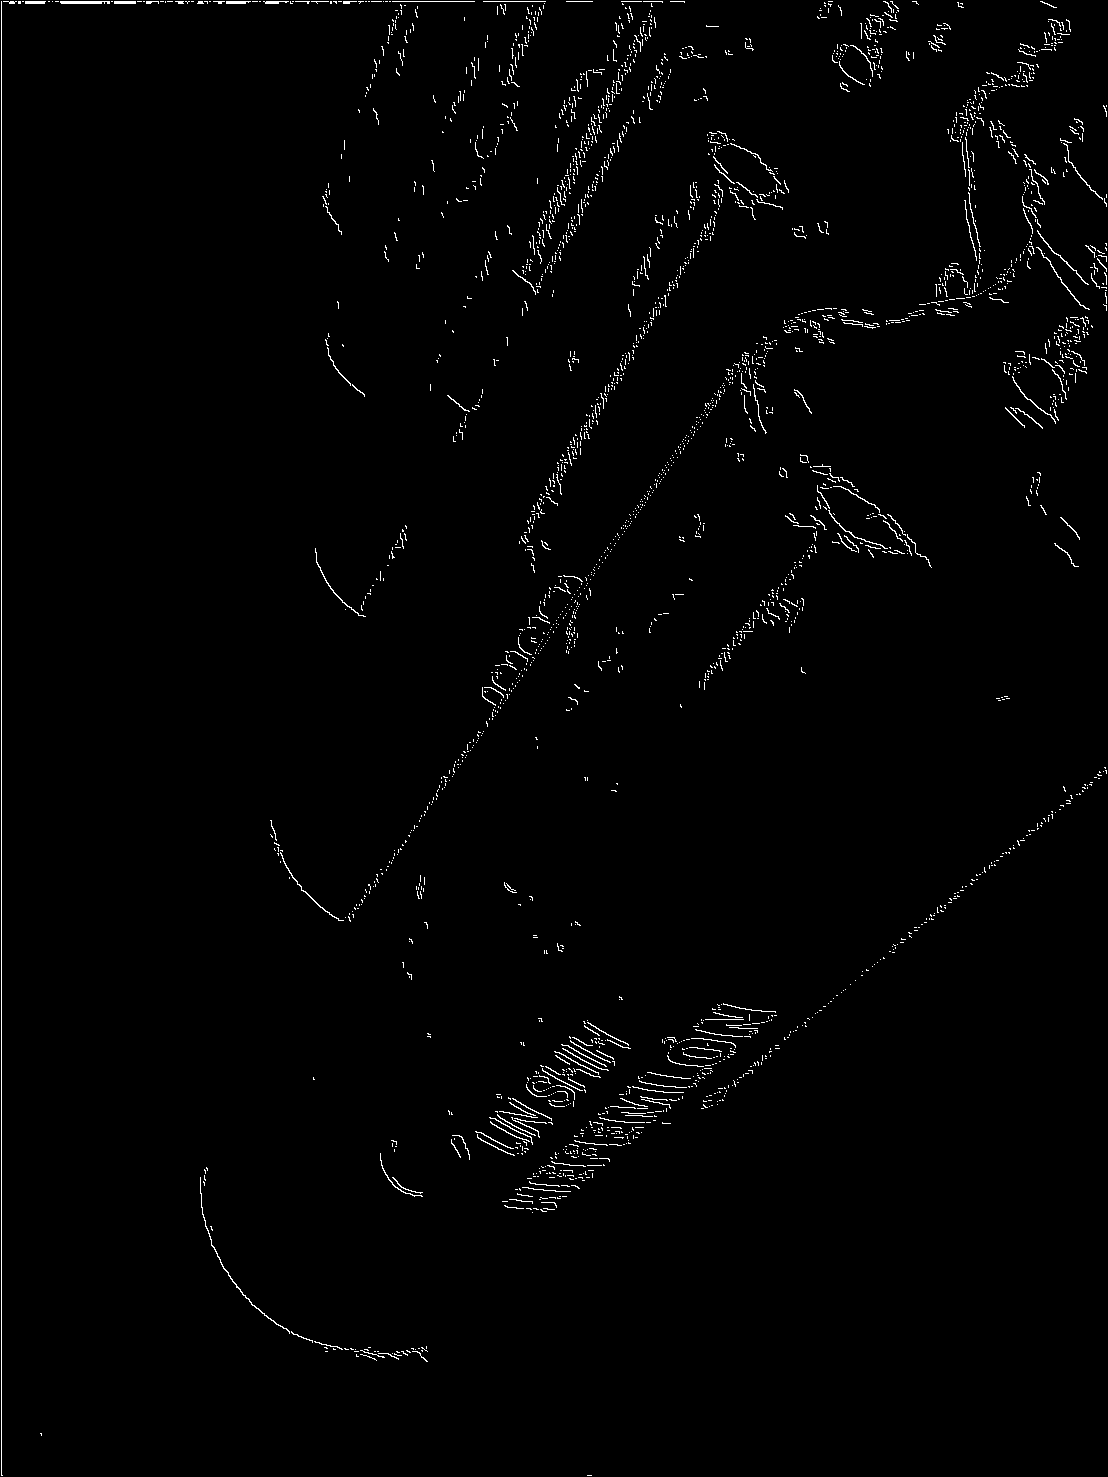

In [ ]:
#color
edge_img1 = color_canny_detect(img1,10,30,80,50)
cv2.imwrite('your_path', edge_img1)
cv2_imshow(edge_img1)

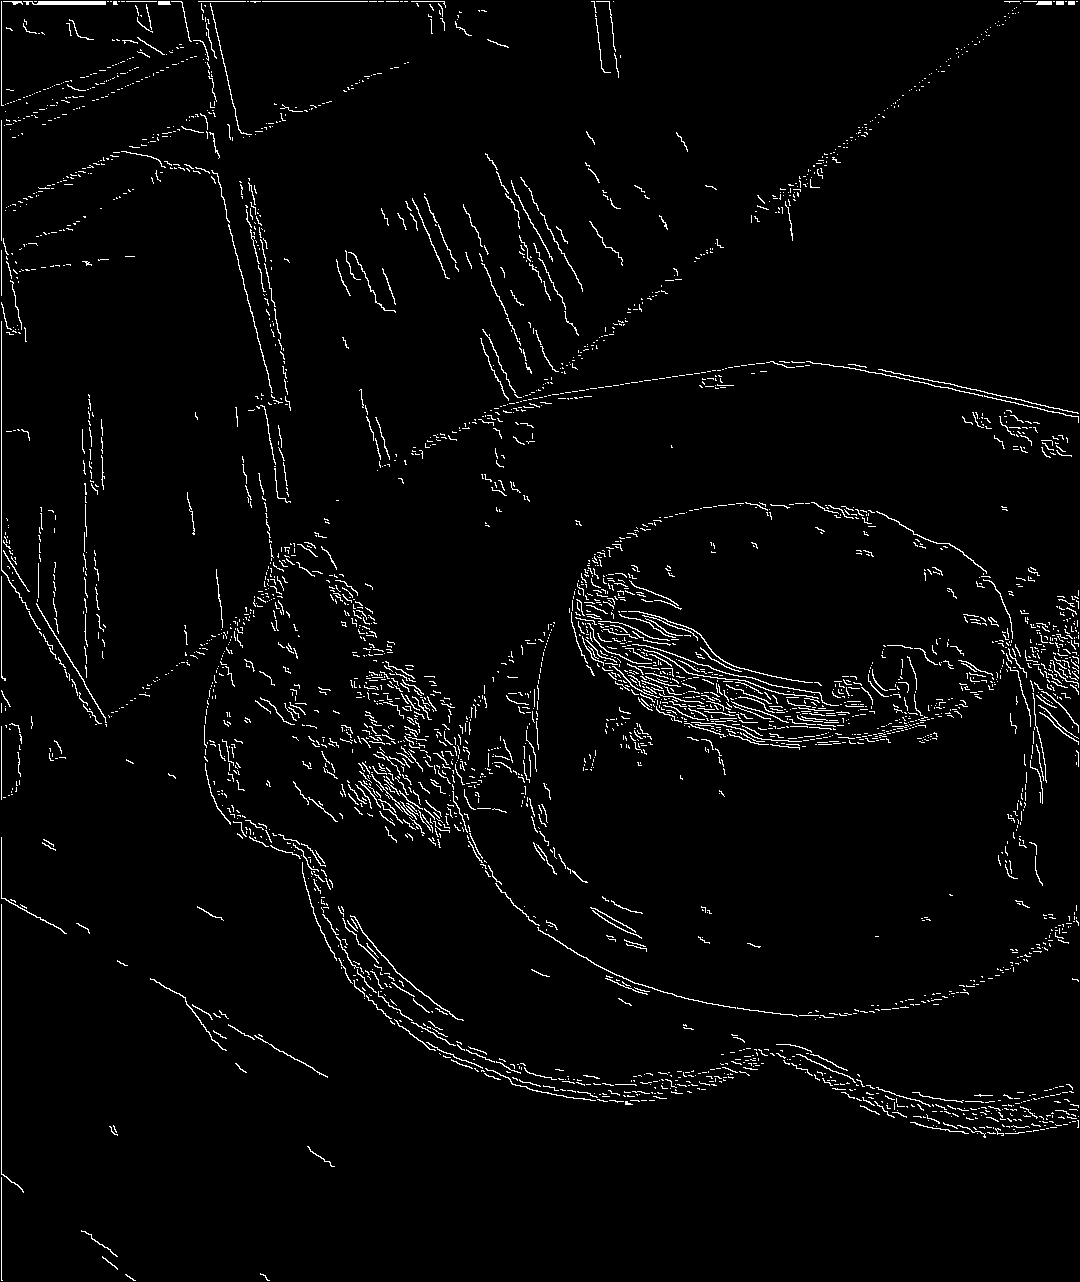

In [ ]:
edge_img2 = canny_detect(img2,10,5,50,50)
cv2.imwrite('your_path', edge_img2)
cv2_imshow(edge_img2)

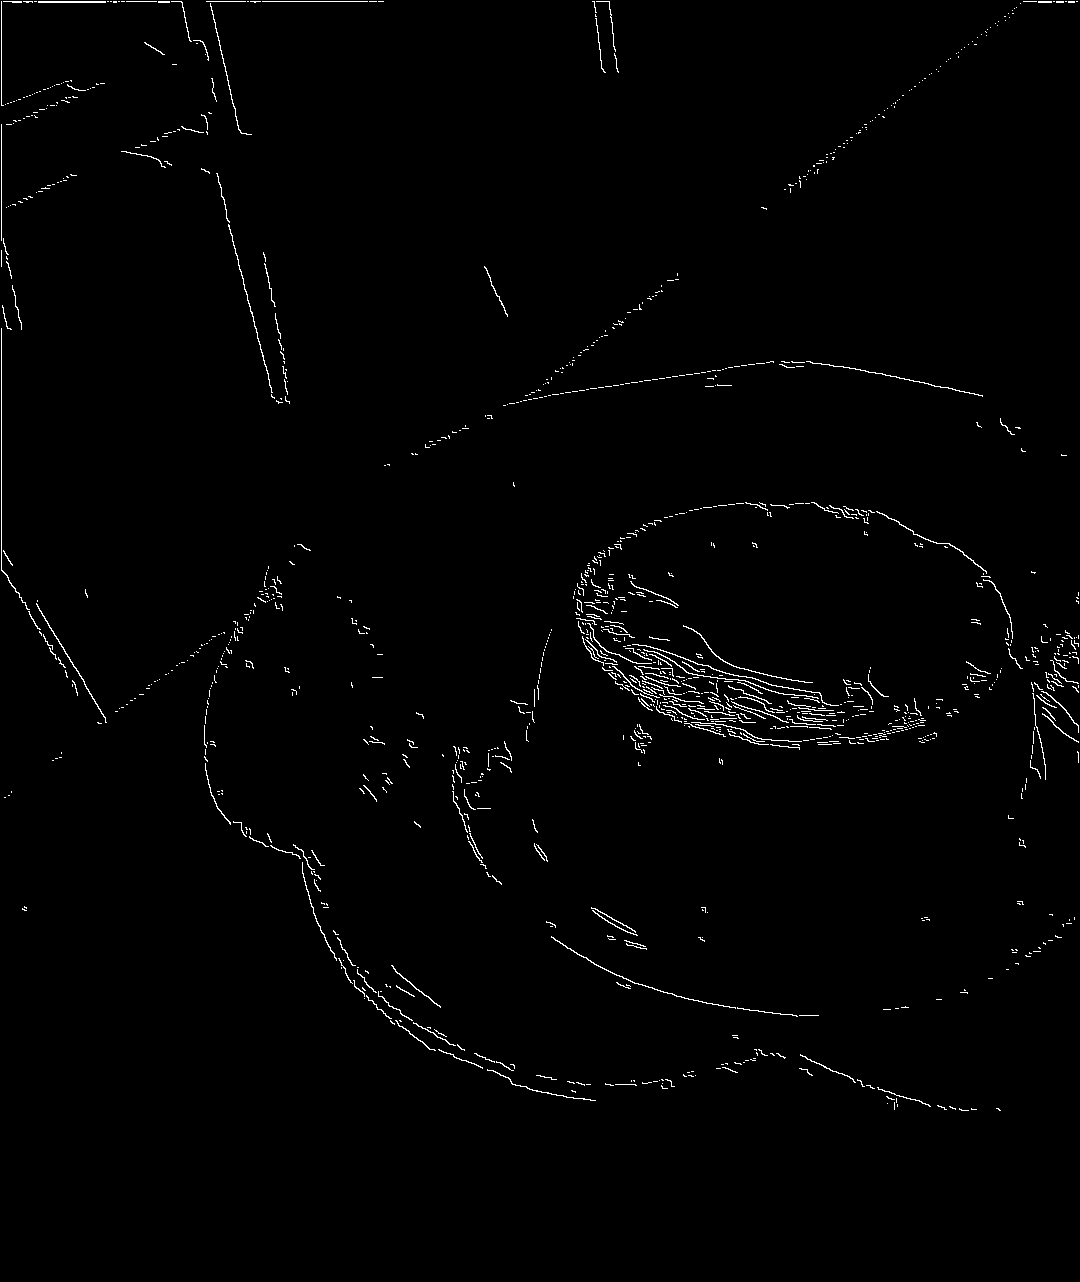

In [ ]:
edge_img2 = canny_detect(img2,10,50,100,50)
cv2.imwrite('your_path', edge_img2)
cv2_imshow(edge_img2)

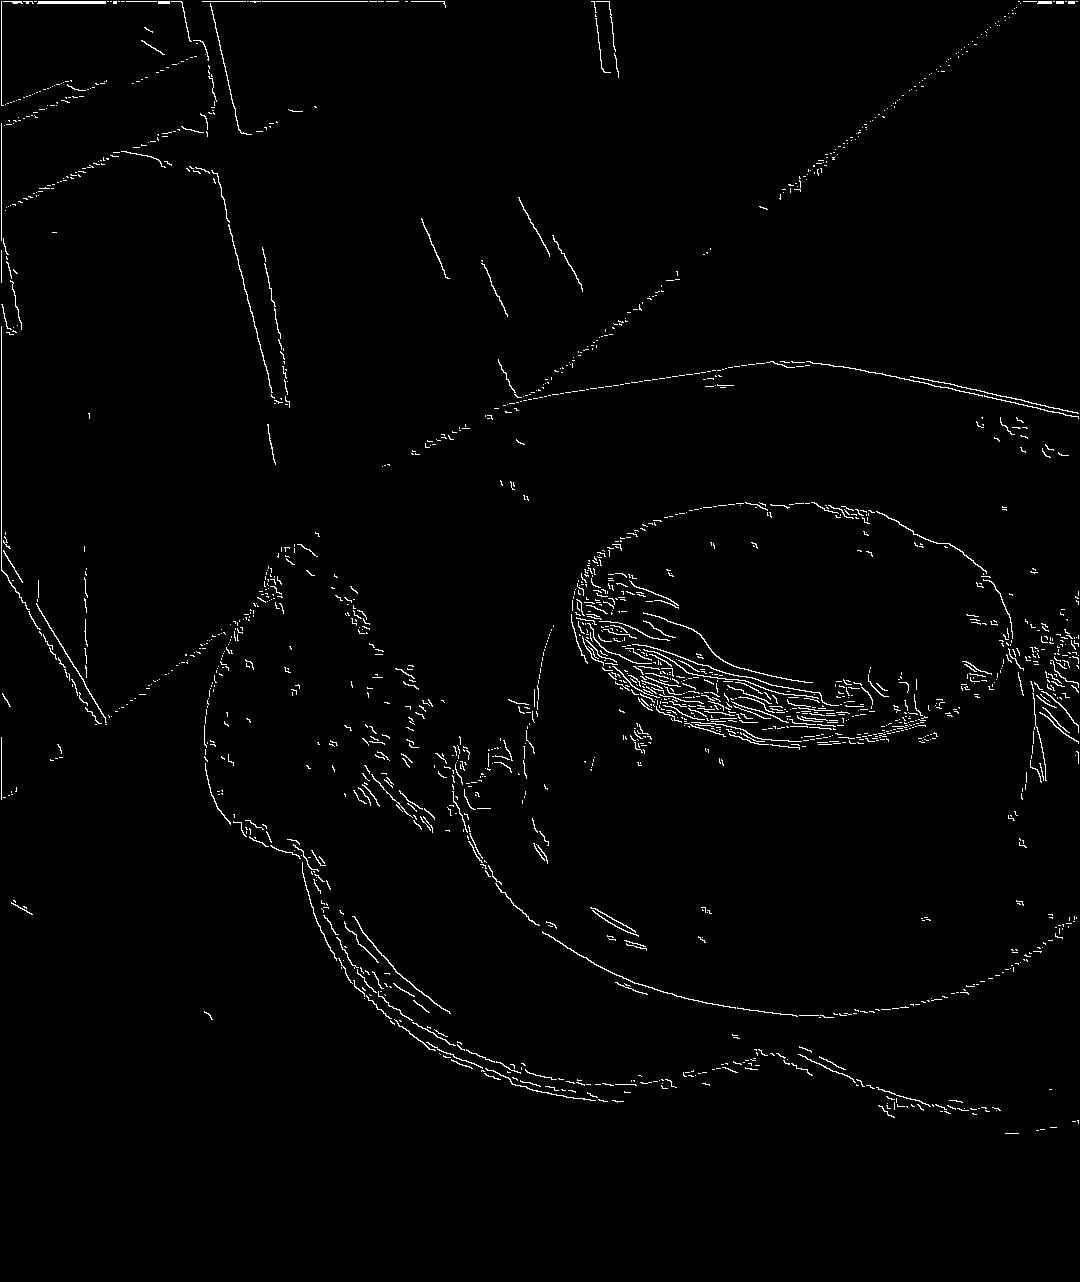

In [ ]:
edge_img2 = canny_detect(img2,10,30,80,50)
cv2.imwrite('your_path', edge_img2)
cv2_imshow(edge_img2)

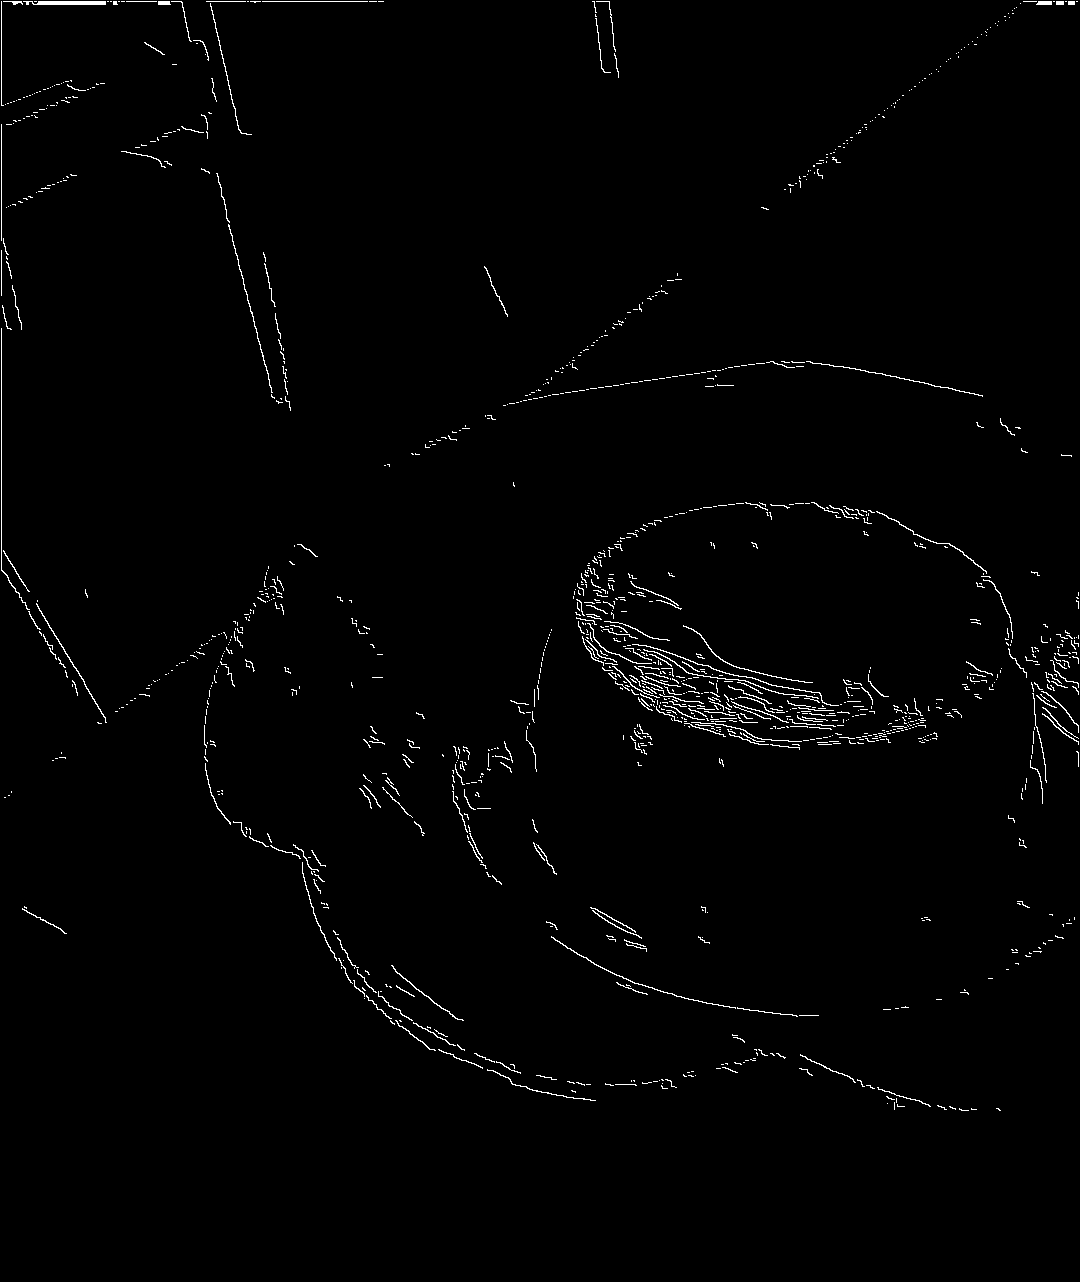

In [ ]:
edge_img2 = canny_detect(img2,10,5,100,50)
cv2.imwrite('your_path', edge_img2)
cv2_imshow(edge_img2)

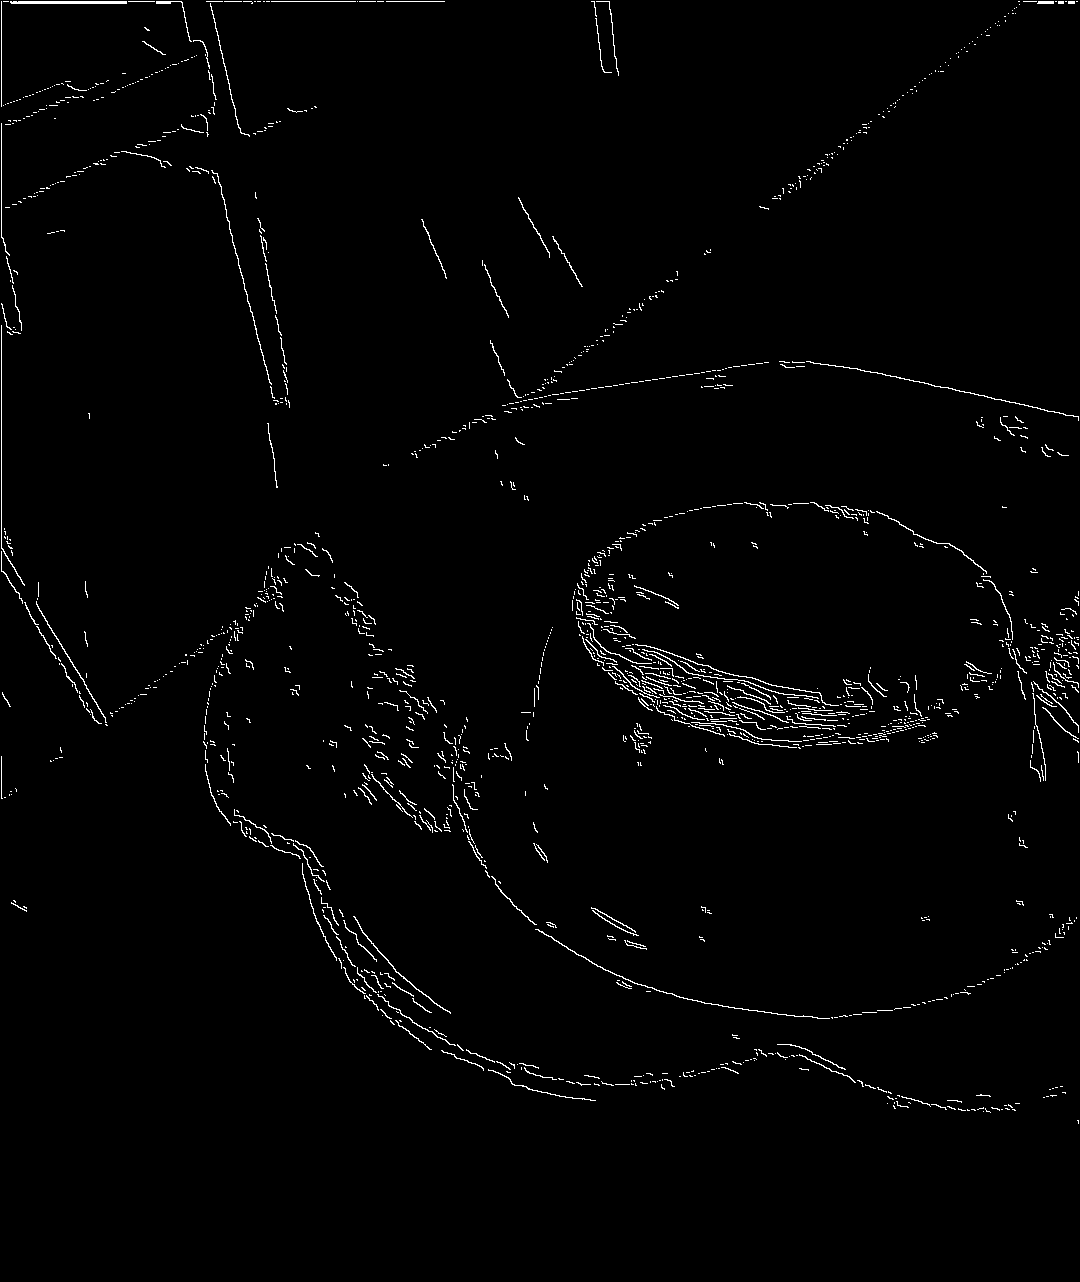

In [ ]:
#color
edge_img2 = color_canny_detect(img2,10,30,80,50)
cv2.imwrite('your_path', edge_img2)
cv2_imshow(edge_img2)

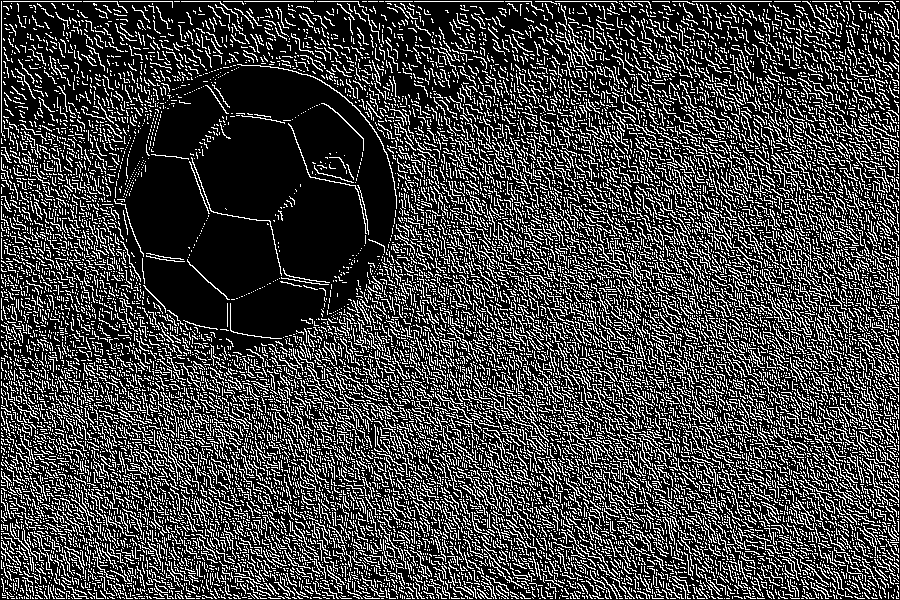

In [ ]:
edge_img4 = canny_detect(img4,10,5,50,50)
cv2.imwrite('your_path', edge_img4)
cv2_imshow(edge_img4)

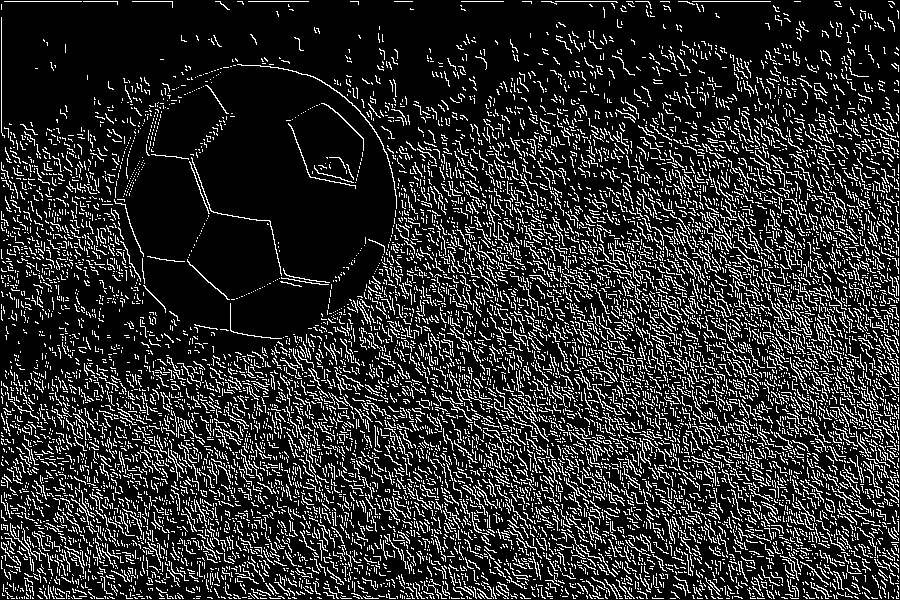

In [ ]:
edge_img4 = canny_detect(img4,10,50,100,50)
cv2.imwrite('your_path', edge_img4)
cv2_imshow(edge_img4)

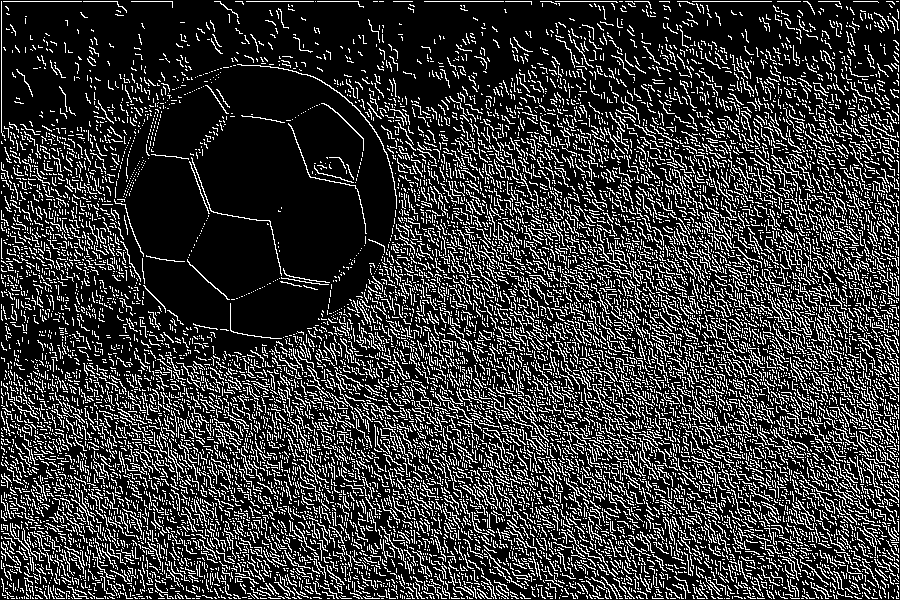

In [ ]:
edge_img4 = canny_detect(img4,10,30,80,50)
cv2.imwrite('your_path', edge_img4)
cv2_imshow(edge_img4)

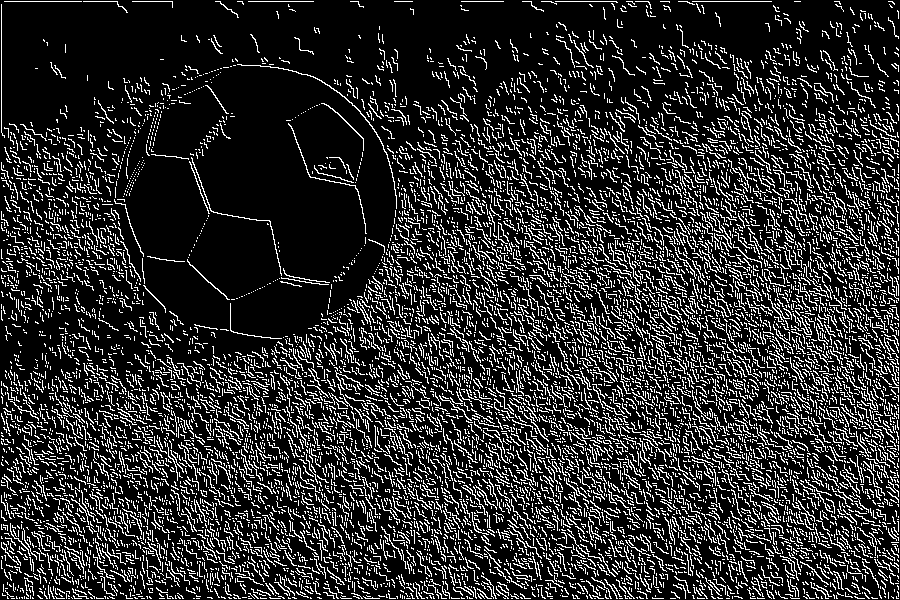

In [ ]:
edge_img4 = canny_detect(img4,10,5,100,50)
cv2.imwrite('your_path', edge_img4)
cv2_imshow(edge_img4)

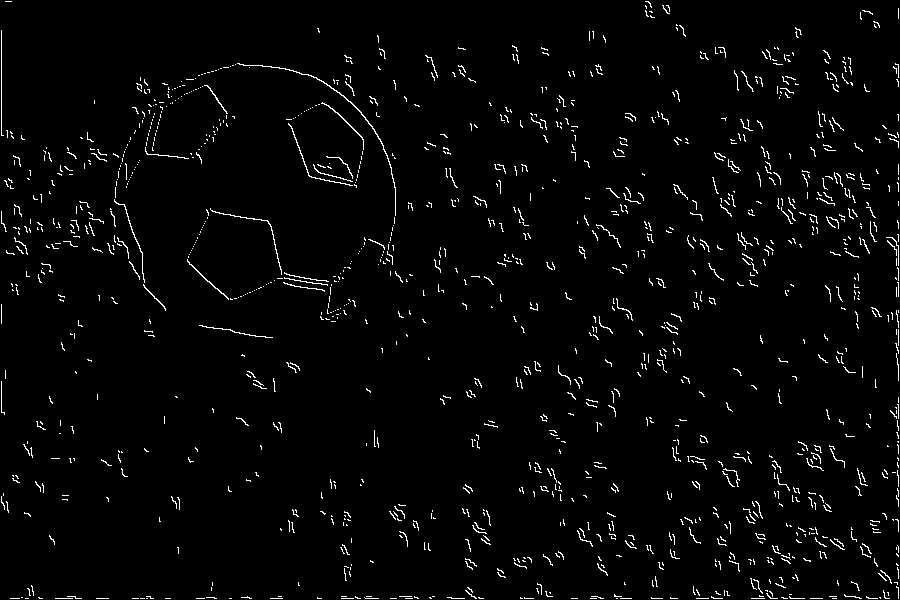

In [ ]:
edge_img4 = color_canny_detect(img4,10,30,80,50)
cv2.imwrite('your_path', edge_img4)
cv2_imshow(edge_img4)

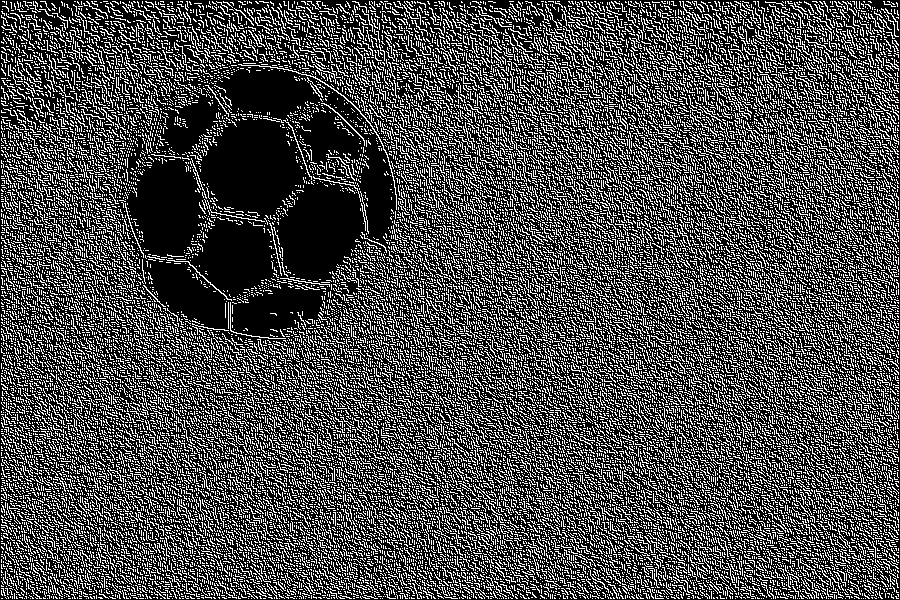

In [ ]:
edge_img4 = sharp_edge_detect(img4,10,30,80,50)
cv2.imwrite('your_path', edge_img4)
cv2_imshow(edge_img4)

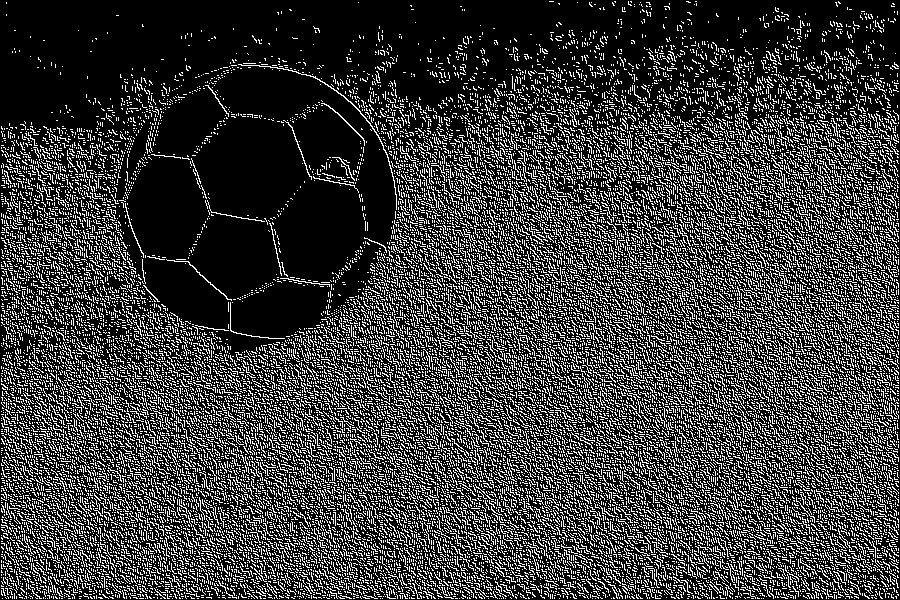

In [ ]:
edge_img4 = sharp_edge_detect(img4,10,200,225,50)
cv2.imwrite('your_path', edge_img4)
cv2_imshow(edge_img4)

Open CV canny detection result

In [ ]:
blur_img1 = mygaussianblur(img1,3,1)
blur_img2 = mygaussianblur(img2,3,1)
blur_img3 = mygaussianblur(img3,3,1)
blur_img4 = mygaussianblur(img4,3,1)

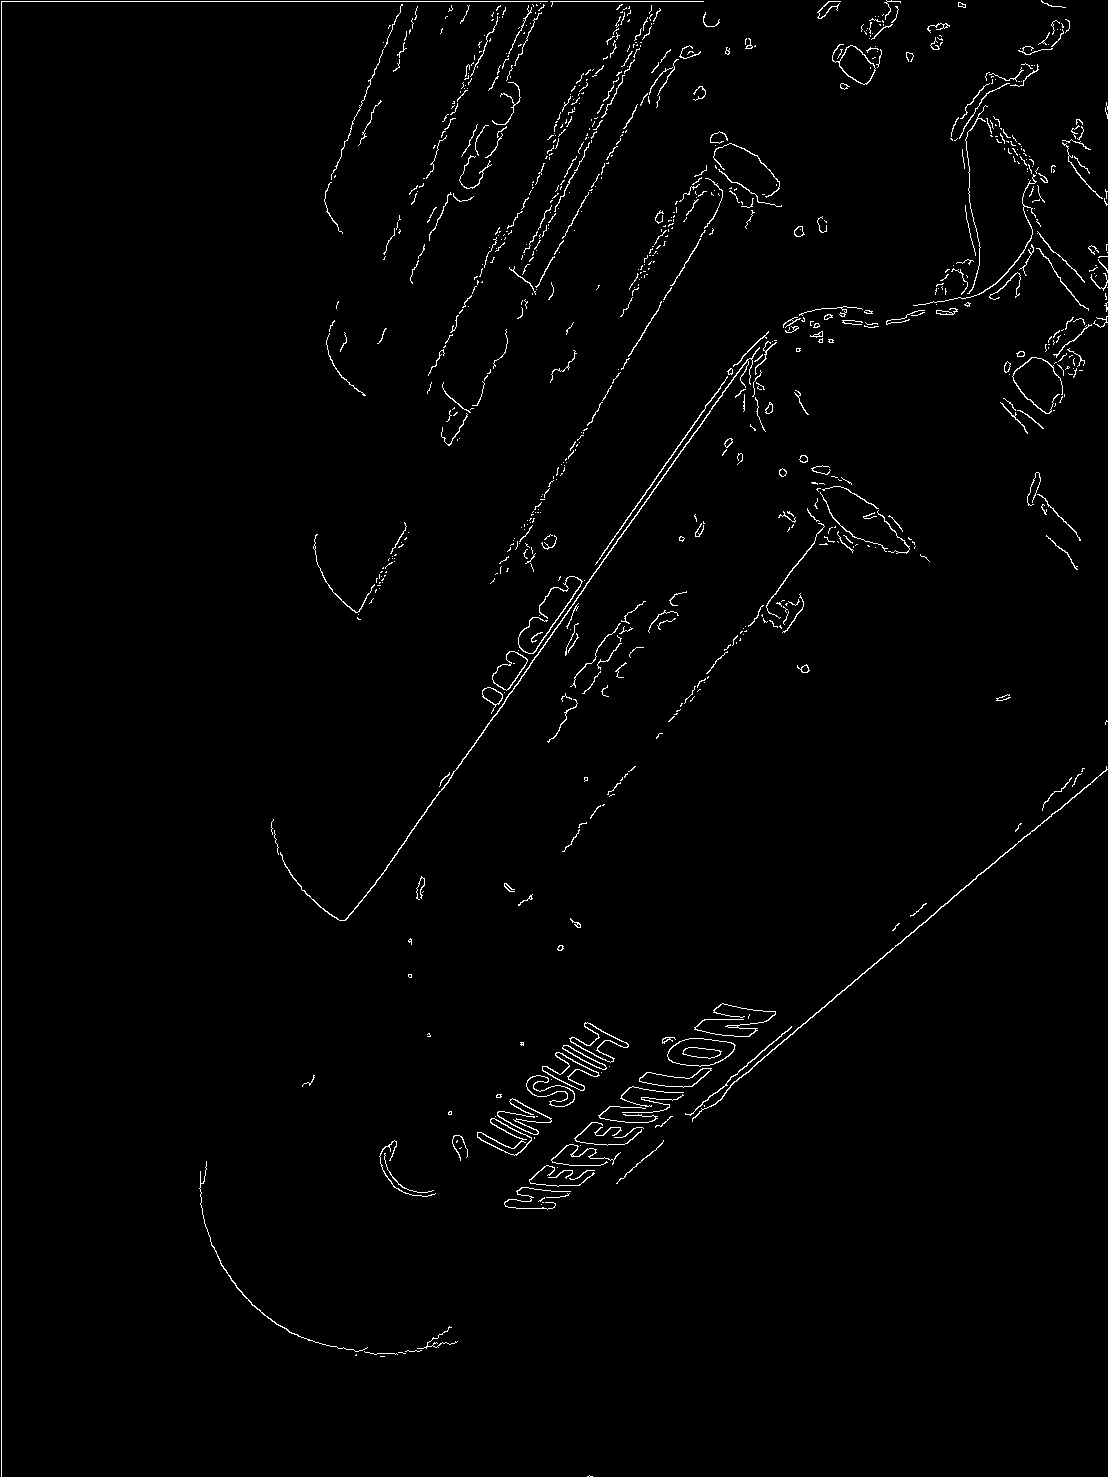

In [ ]:
ocv_edges1 = cv2.Canny(blur_img1, 30, 80)
cv2.imwrite('your_path', ocv_edges1)
cv2_imshow(ocv_edges1)

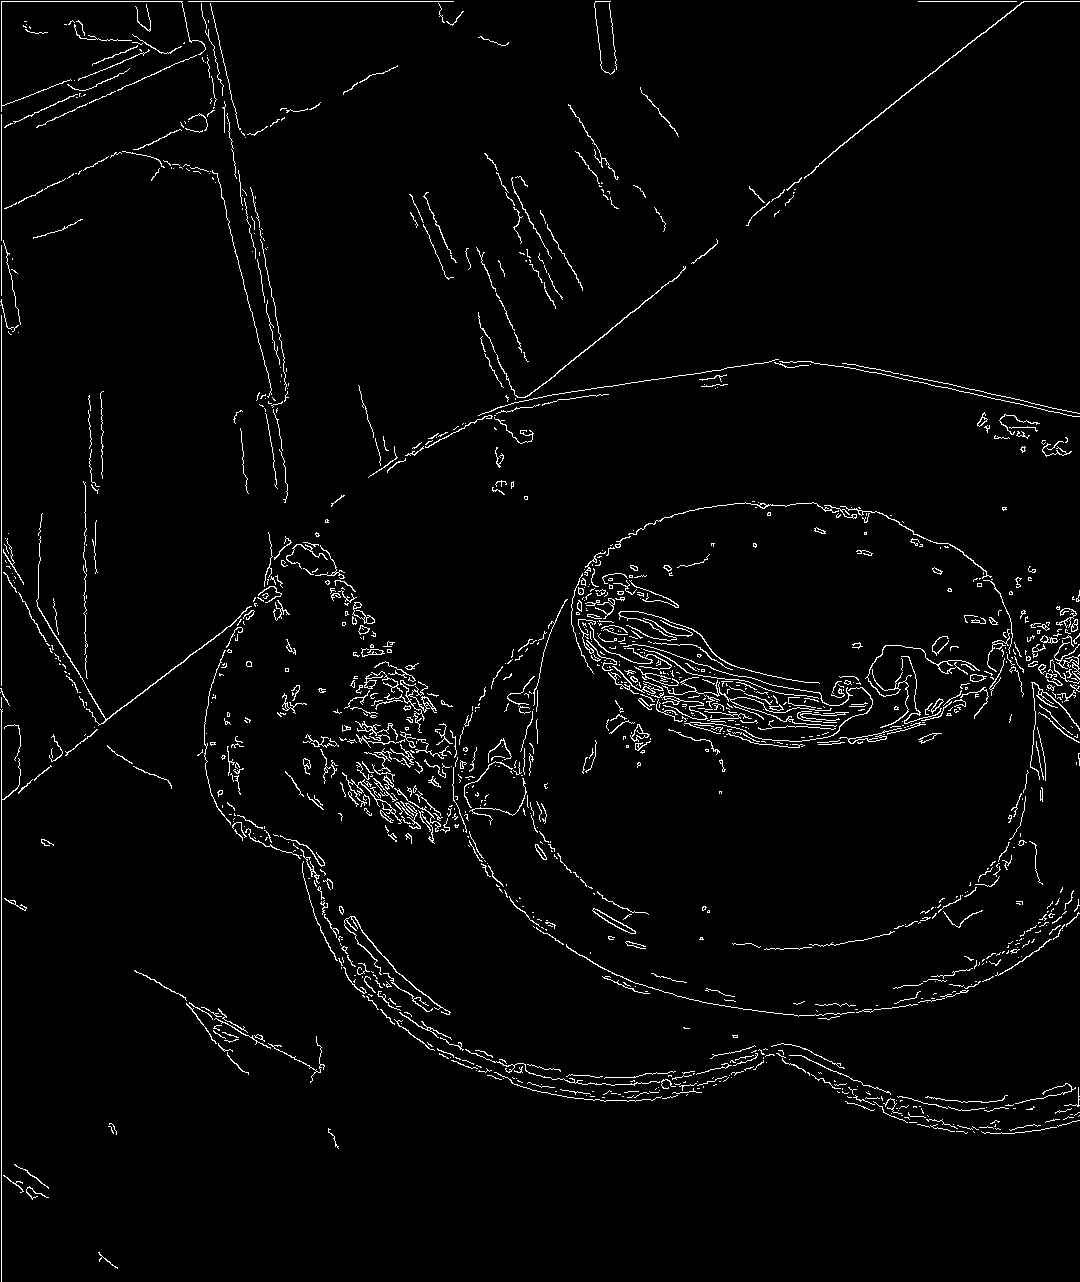

In [ ]:
ocv_edges2 = cv2.Canny(blur_img2, 30, 80)
cv2.imwrite('your_path', ocv_edges2)
cv2_imshow(ocv_edges2)

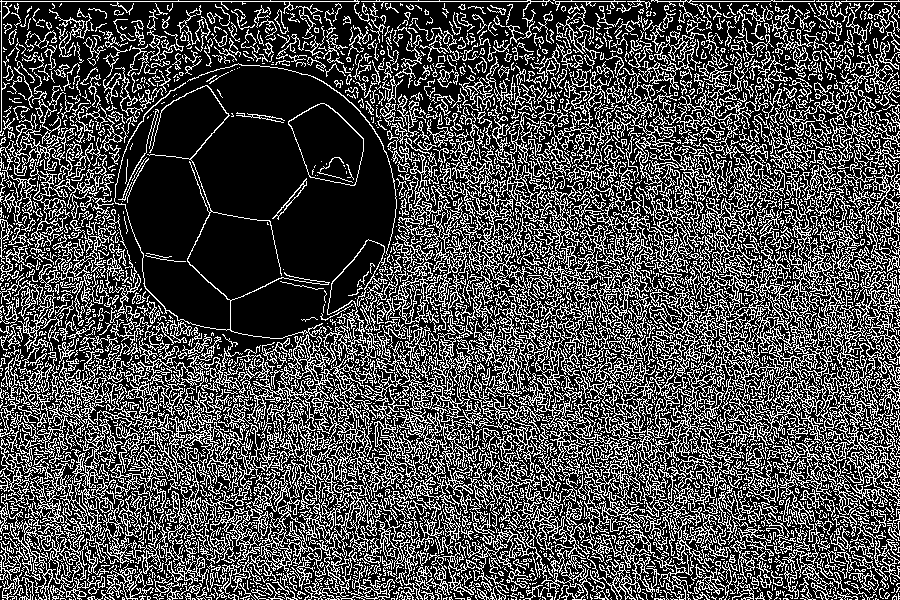

In [ ]:
ocv_edges4 = cv2.Canny(blur_img4, 30, 80)
cv2.imwrite('your_path', ocv_edges4)
cv2_imshow(ocv_edges4)